In [170]:
%pip install pandas numpy matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import importlib.util
import sys
import os

data = pd.read_csv("../dataset/dataset1.csv")

data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Exploratory Data Analysis (EDA)

### 1. Statistik Dasar Data Tiap Kolom/Fitur
#### Fitur Numerik


In [22]:
numeric_features = data.select_dtypes(include=[np.number])
numeric_stats = numeric_features.describe(percentiles=[.25, .5, .75]).T
print(numeric_stats)

                 count       mean        std    min   25%    50%    75%  \
SeniorCitizen   7043.0   0.162147   0.368612   0.00   0.0   0.00   0.00   
tenure          7043.0  32.371149  24.559481   0.00   9.0  29.00  55.00   
MonthlyCharges  7043.0  64.761692  30.090047  18.25  35.5  70.35  89.85   

                   max  
SeniorCitizen     1.00  
tenure           72.00  
MonthlyCharges  118.75  


#### Fitur Kategorikal


In [23]:
categorical_features = data.select_dtypes(exclude=[np.number])
categorical_stats = categorical_features.describe().T
print(categorical_stats)

                 count unique               top  freq
customerID        7043   7043        3186-AJIEK     1
gender            7043      2              Male  3555
Partner           7043      2                No  3641
Dependents        7043      2                No  4933
PhoneService      7043      2               Yes  6361
MultipleLines     7043      3                No  3390
InternetService   7043      3       Fiber optic  3096
OnlineSecurity    7043      3                No  3498
OnlineBackup      7043      3                No  3088
DeviceProtection  7043      3                No  3095
TechSupport       7043      3                No  3473
StreamingTV       7043      3                No  2810
StreamingMovies   7043      3                No  2785
Contract          7043      3    Month-to-month  3875
PaperlessBilling  7043      2               Yes  4171
PaymentMethod     7043      4  Electronic check  2365
TotalCharges      7043   6531              20.2    11
Churn             7043      

Sebelum melanjutkan ke visualisasi distribusi setiap kolom, sedikit preprocessing lebih awal akan dikenakan pada fitur TotalCharges. Hal itu karena terjadi suatu keanehan terjadi dimana TotalCharges masuk kedalam Fitur Kategorikal

In [8]:
# Pengecekan nilai non-numeric di kolomTotalCharges
non_numeric_total_charges = data[~data['TotalCharges'].apply(lambda x: x.replace('.', '', 1).isdigit())]
print(non_numeric_total_charges)

      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ... 

Dari data yang ada, tampak bahwa kolom TotalCharges memiliki nilai kosong. Ini yang menyebabkan kolom tersebut terdeteksi sebagai fitur kategorikal.

In [24]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
print(data['TotalCharges'].isnull().sum())
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())

11


#### Fitur Numerik Setelah Sedikit Reparasi

In [25]:
numeric_features = data.select_dtypes(include=[np.number])
numeric_stats = numeric_features.describe(percentiles=[.25, .5, .75]).T
print(numeric_stats)

                 count         mean          std    min      25%       50%  \
SeniorCitizen   7043.0     0.162147     0.368612   0.00    0.000     0.000   
tenure          7043.0    32.371149    24.559481   0.00    9.000    29.000   
MonthlyCharges  7043.0    64.761692    30.090047  18.25   35.500    70.350   
TotalCharges    7043.0  2281.916928  2265.270398  18.80  402.225  1397.475   

                    75%      max  
SeniorCitizen      0.00     1.00  
tenure            55.00    72.00  
MonthlyCharges    89.85   118.75  
TotalCharges    3786.60  8684.80  


#### Fitur Kategorikal Setelah Sedikit Reparasi

In [26]:
categorical_features = data.select_dtypes(exclude=[np.number])
categorical_features = categorical_features.drop(columns=['customerID'])
categorical_stats = categorical_features.describe().T
print(categorical_stats)

                 count unique               top  freq
gender            7043      2              Male  3555
Partner           7043      2                No  3641
Dependents        7043      2                No  4933
PhoneService      7043      2               Yes  6361
MultipleLines     7043      3                No  3390
InternetService   7043      3       Fiber optic  3096
OnlineSecurity    7043      3                No  3498
OnlineBackup      7043      3                No  3088
DeviceProtection  7043      3                No  3095
TechSupport       7043      3                No  3473
StreamingTV       7043      3                No  2810
StreamingMovies   7043      3                No  2785
Contract          7043      3    Month-to-month  3875
PaperlessBilling  7043      2               Yes  4171
PaymentMethod     7043      4  Electronic check  2365
Churn             7043      2                No  5174


### 2. Persebaran Data untuk Setiap Kolom/Fitur

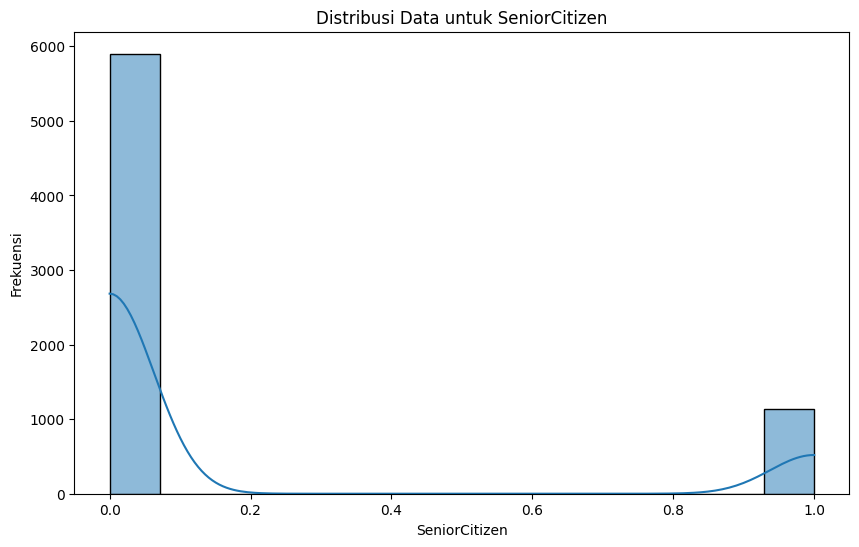

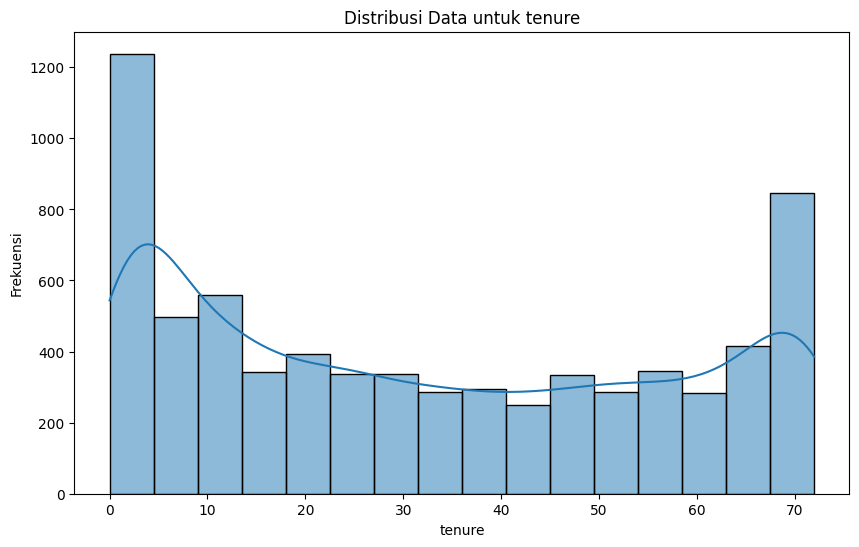

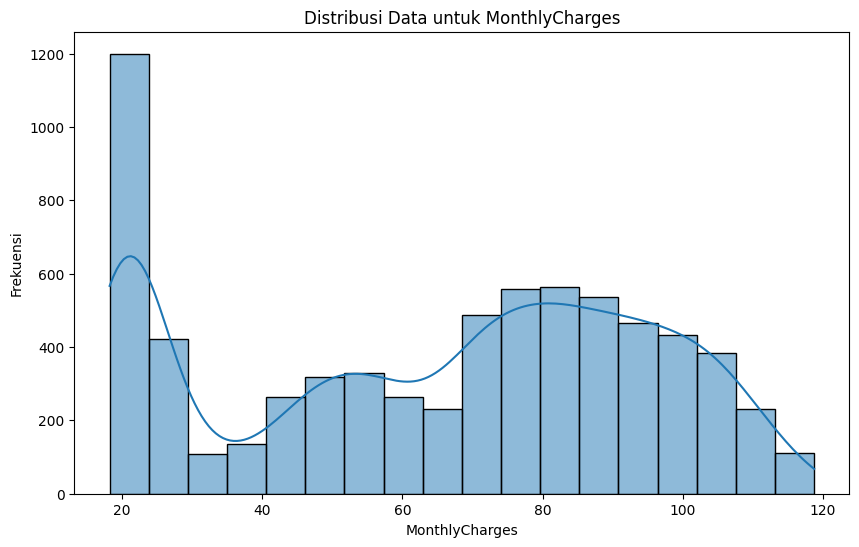

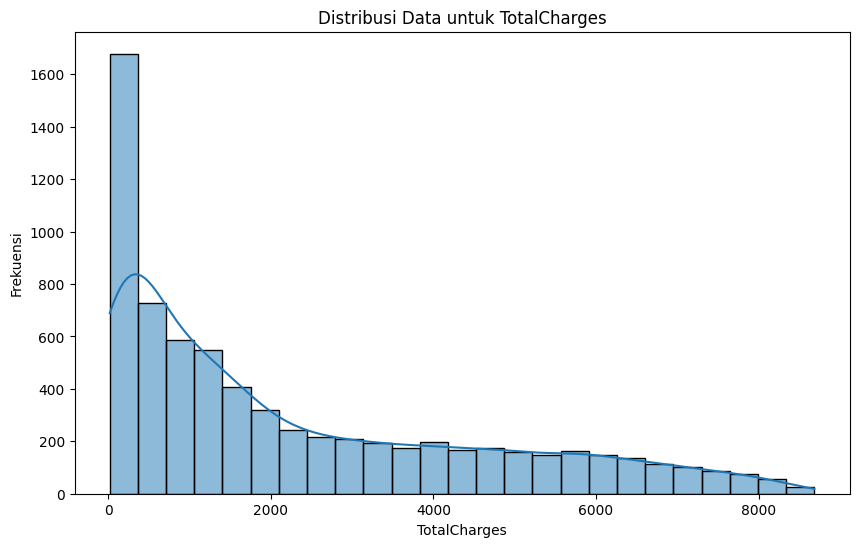

In [27]:
for column in numeric_features.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(numeric_features[column], kde=True)
    plt.title(f'Distribusi Data untuk {column}')
    plt.xlabel(column)
    plt.ylabel('Frekuensi')
    plt.show()

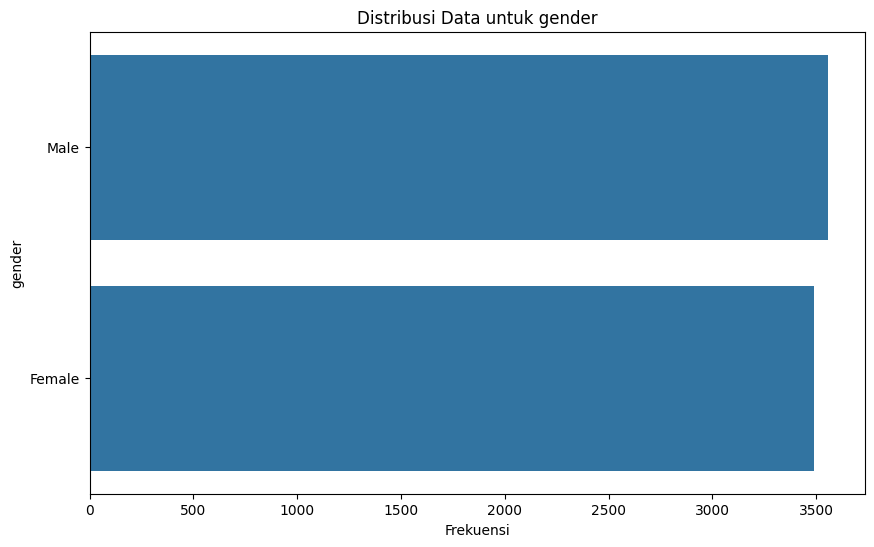

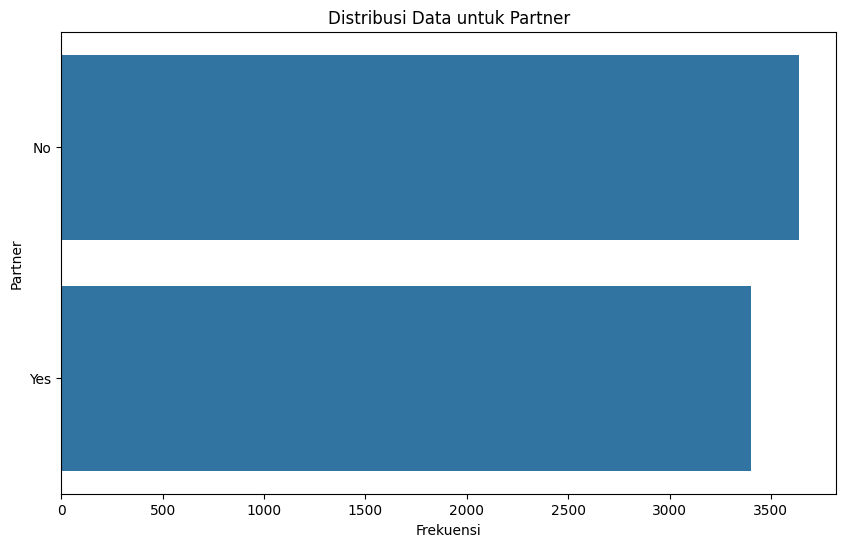

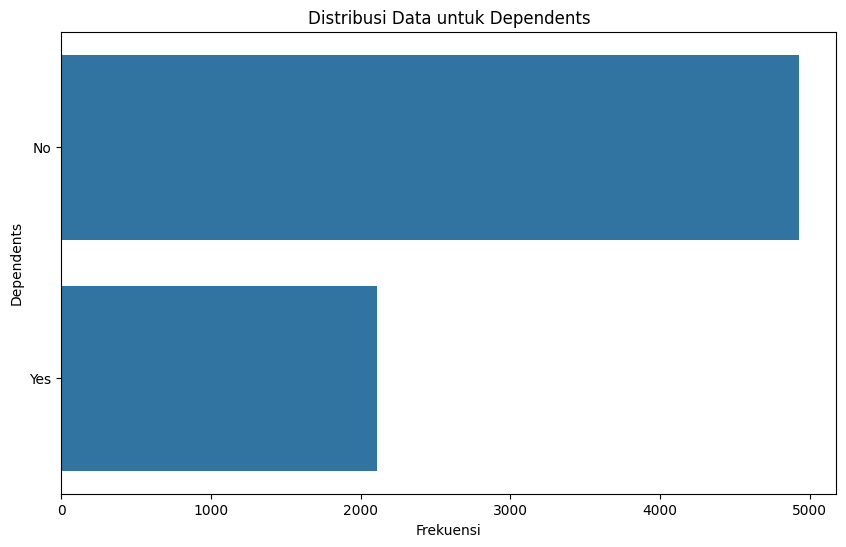

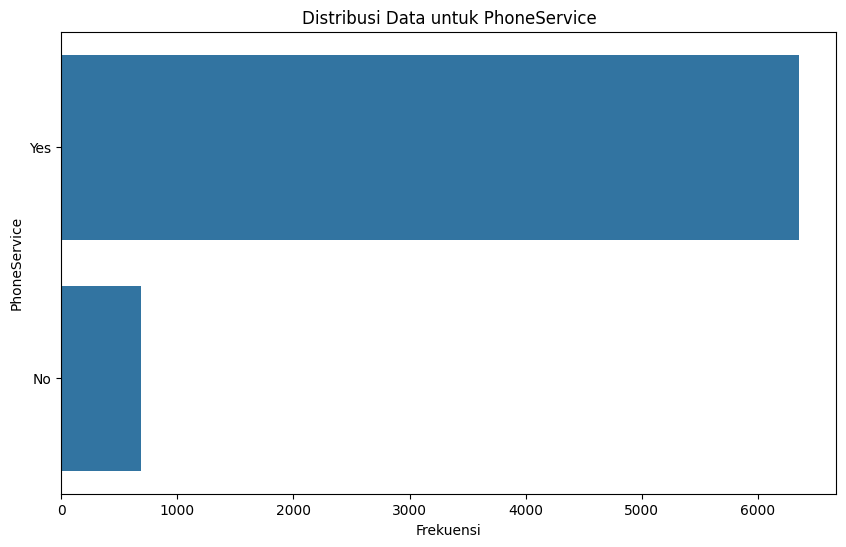

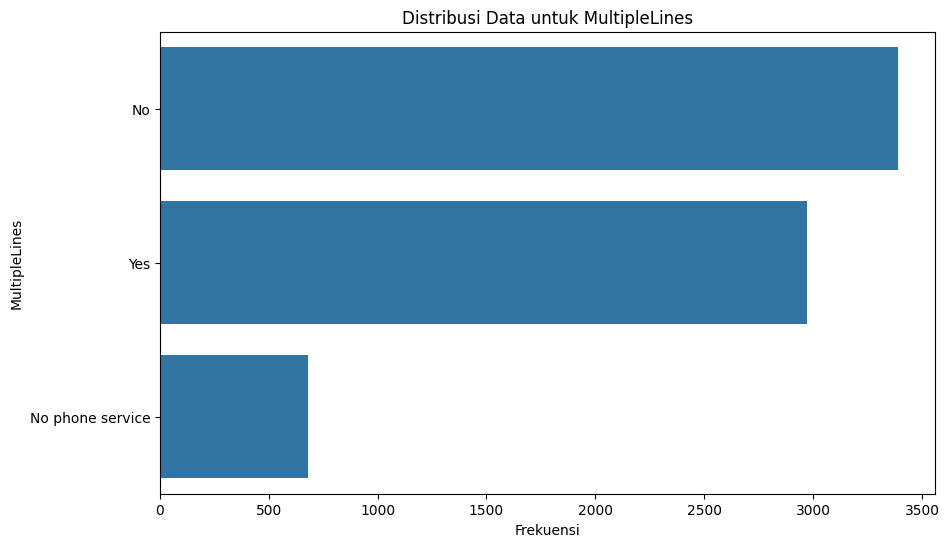

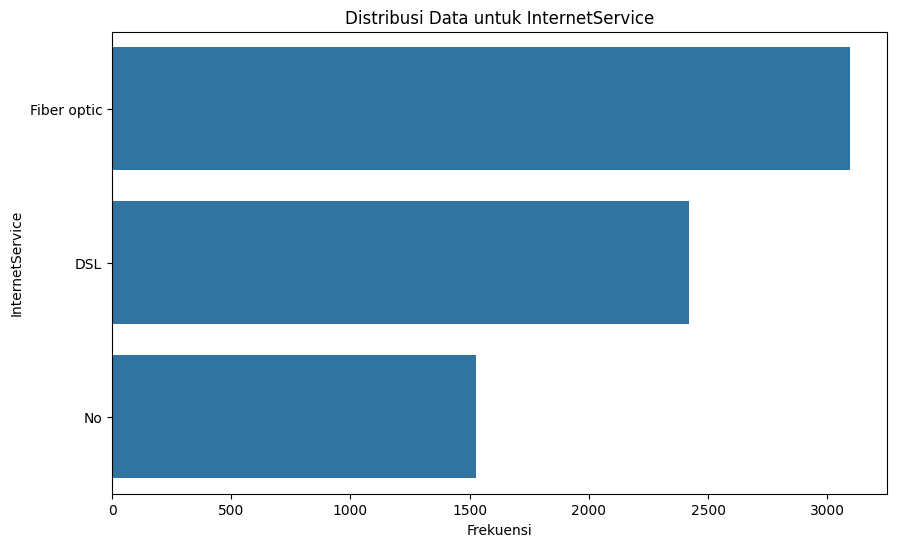

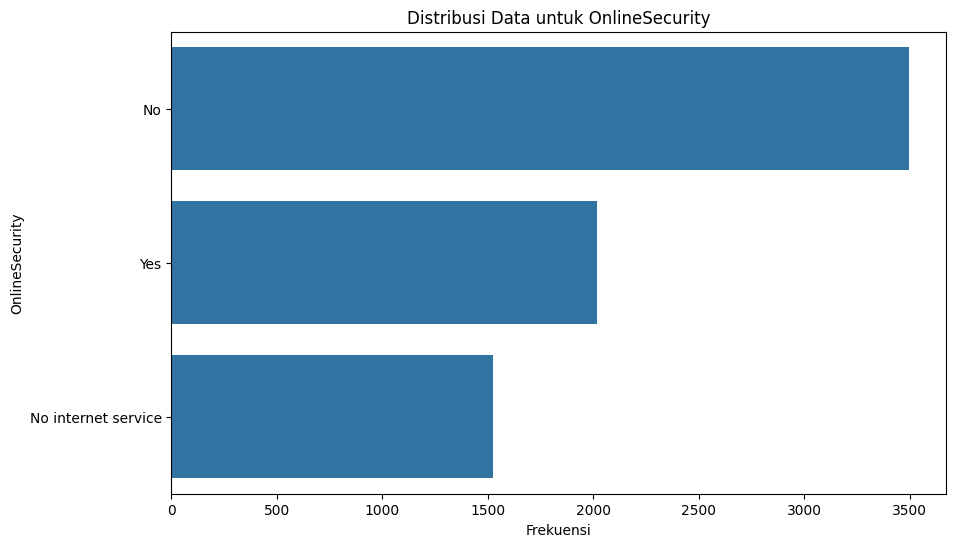

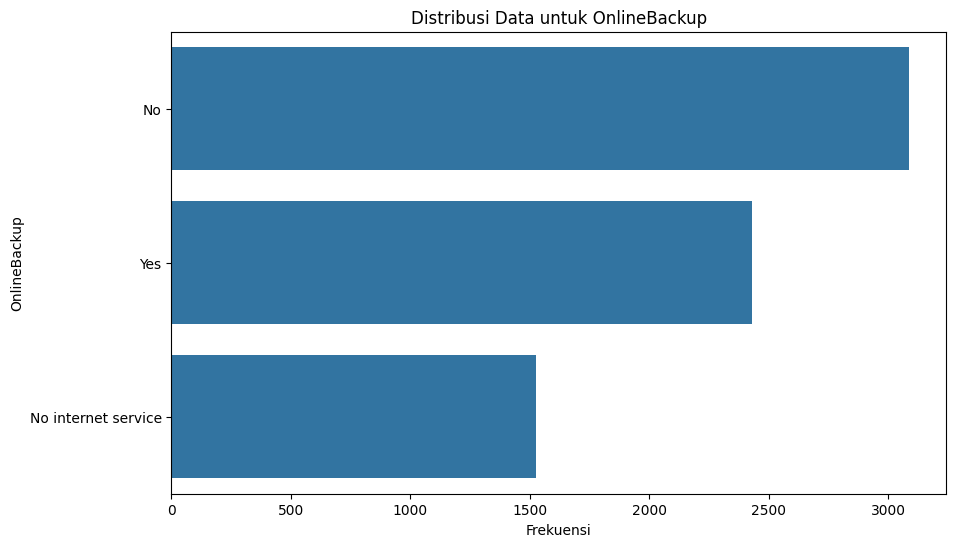

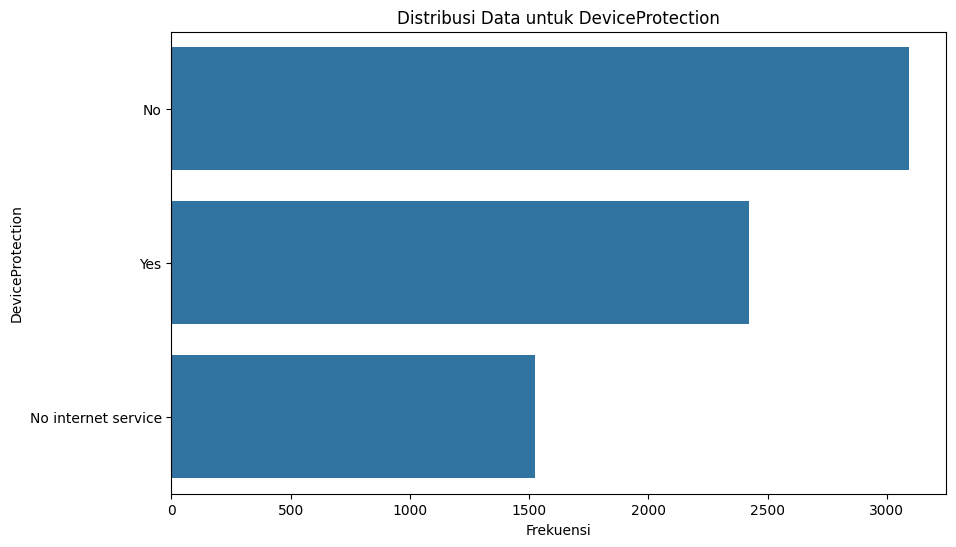

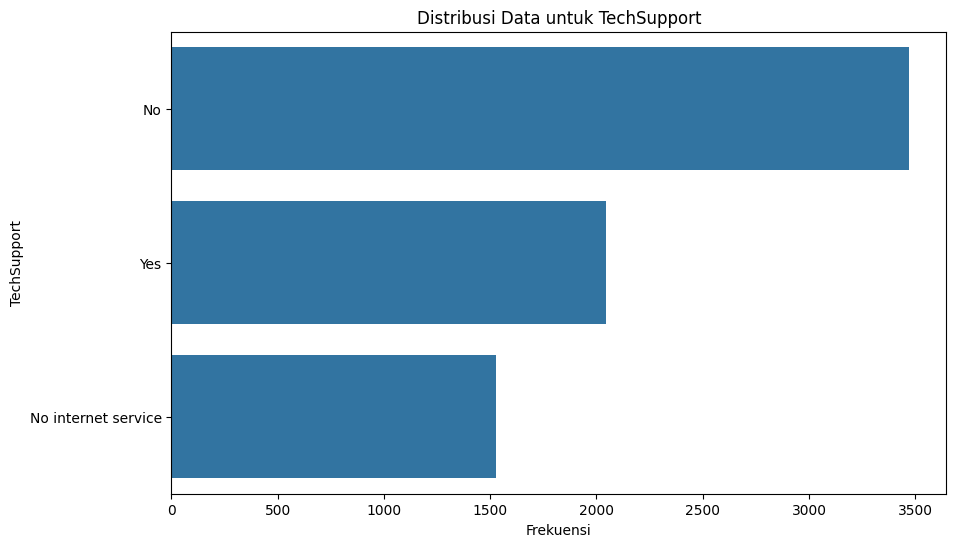

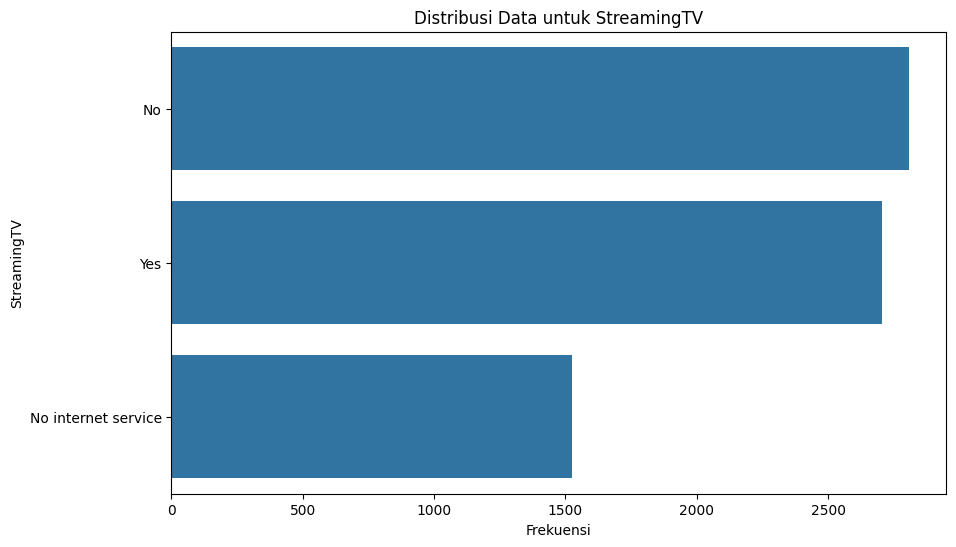

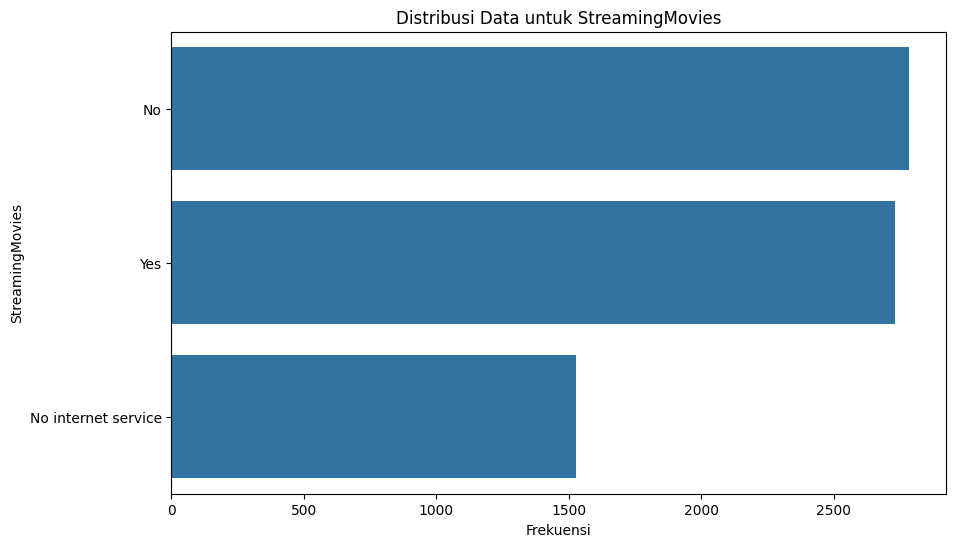

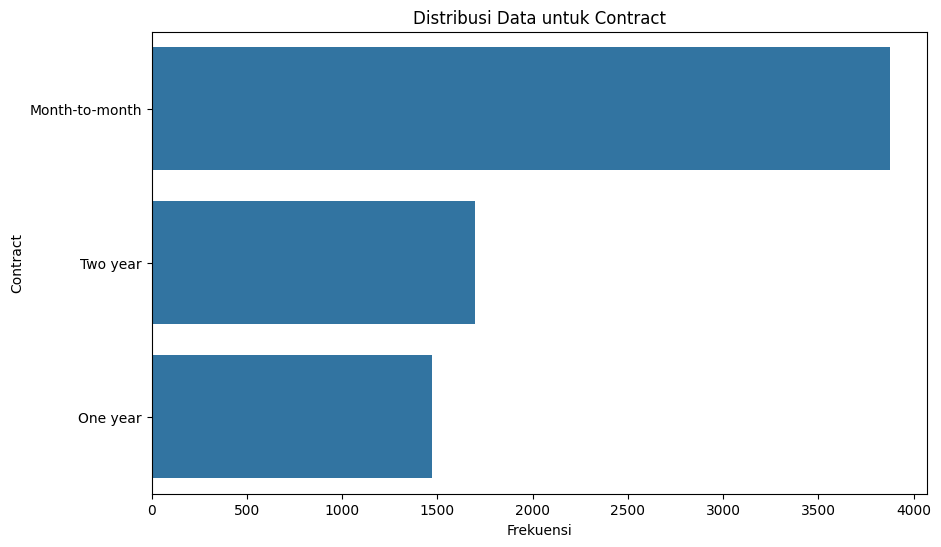

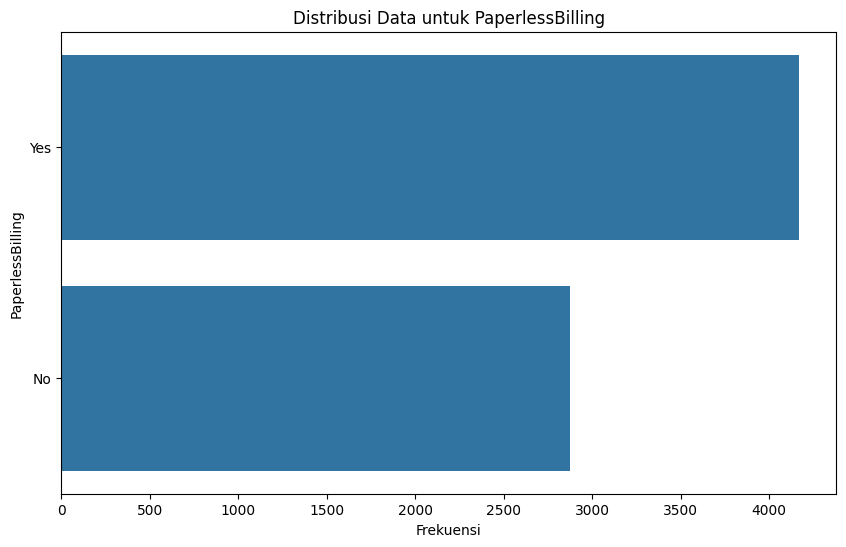

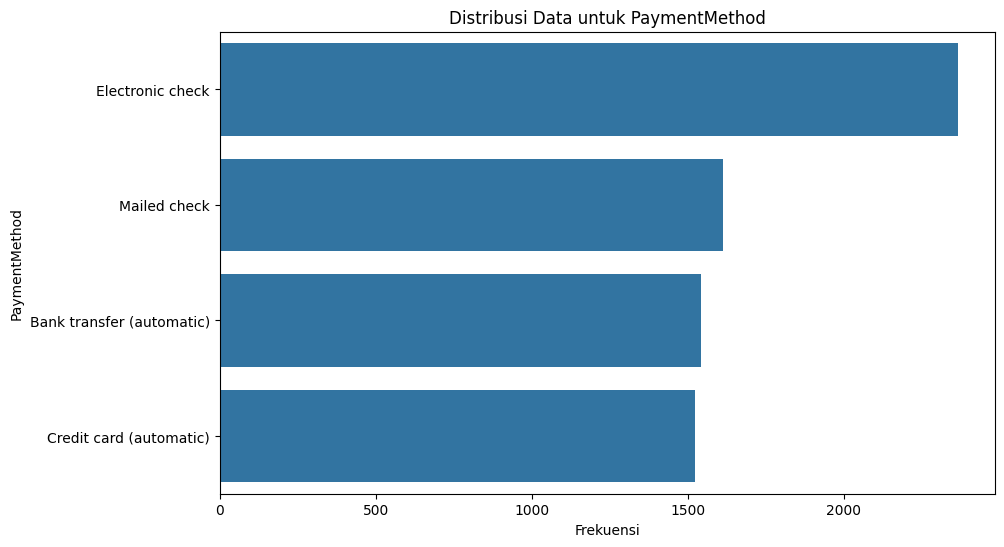

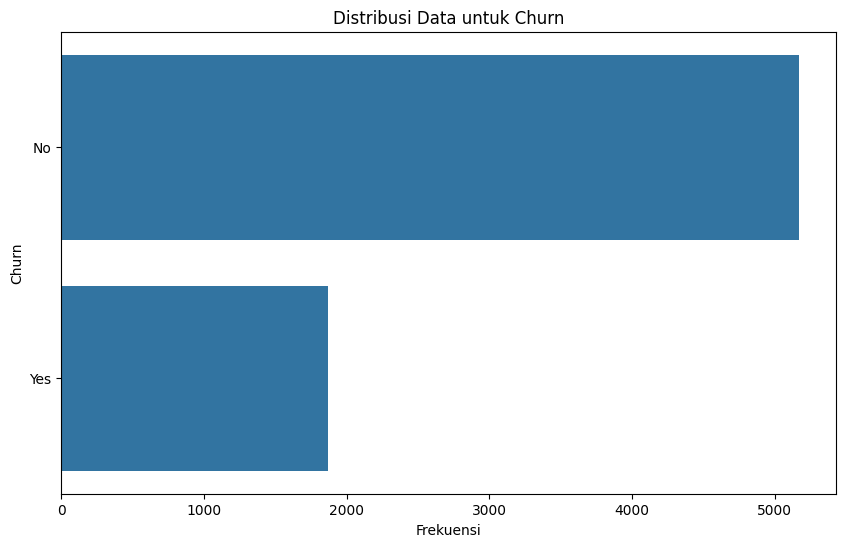

In [28]:
for column in categorical_features.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=categorical_features[column], order=categorical_features[column].value_counts().index)
    plt.title(f'Distribusi Data untuk {column}')
    plt.xlabel('Frekuensi')
    plt.ylabel(column)
    plt.show()

### 3. Pengecekan Outlier Menggunakan IQR


Analisis untuk tenure:
Jumlah outlier: 0
Persentase outlier: 0.00%


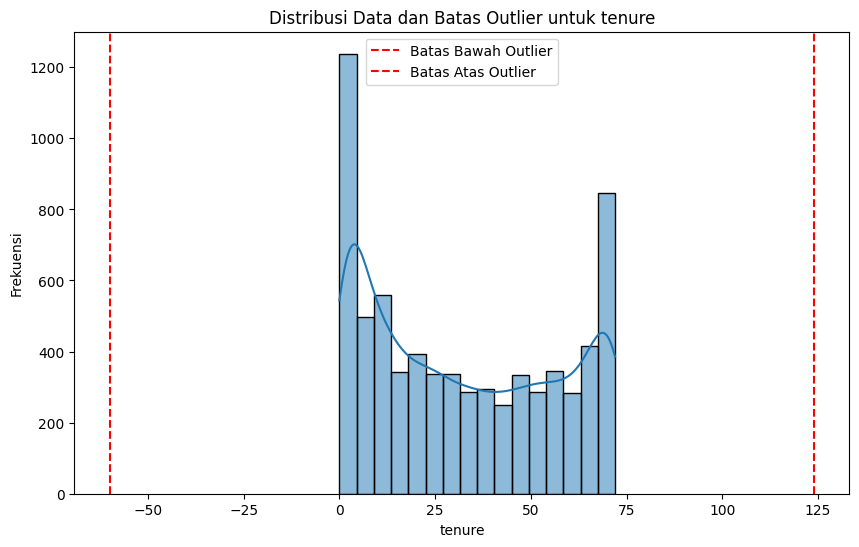


Analisis untuk MonthlyCharges:
Jumlah outlier: 0
Persentase outlier: 0.00%


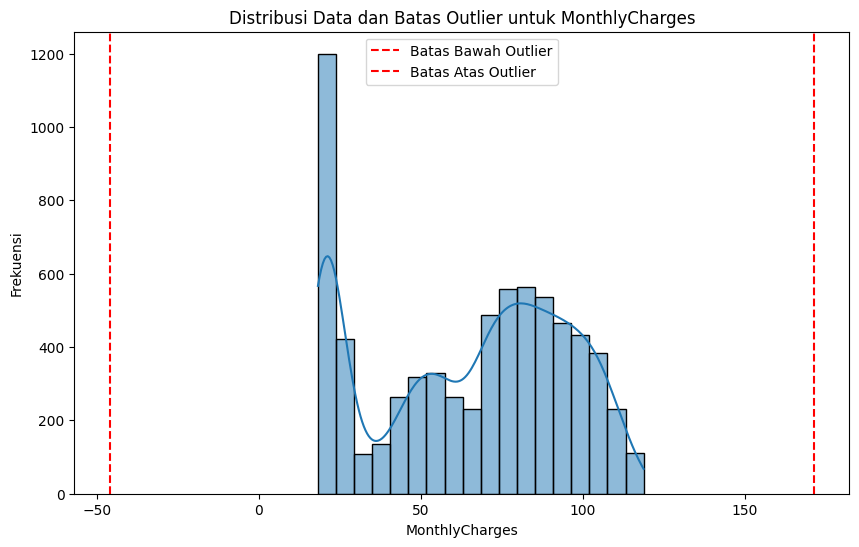


Analisis untuk TotalCharges:
Jumlah outlier: 0
Persentase outlier: 0.00%


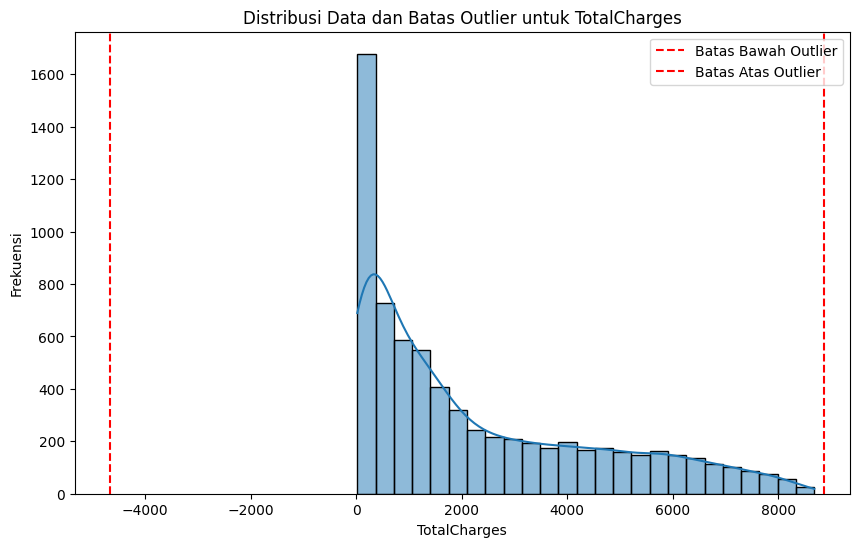

In [29]:
for column in numeric_features.columns:
    if column == "SeniorCitizen":
        continue

    Q1 = numeric_features[column].quantile(0.25)
    Q3 = numeric_features[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
        
    outliers = numeric_features[(numeric_features[column] < lower_bound) | (numeric_features[column] > upper_bound)]
        
    print(f"\nAnalisis untuk {column}:")
    print(f"Jumlah outlier: {len(outliers)}")
    print(f"Persentase outlier: {len(outliers) / len(numeric_features) * 100:.2f}%")
        
    # Visualisasi
    plt.figure(figsize=(10, 6))
    sns.histplot(numeric_features[column], kde=True)
    plt.axvline(lower_bound, color='r', linestyle='--', label='Batas Bawah Outlier')
    plt.axvline(upper_bound, color='r', linestyle='--', label='Batas Atas Outlier')
    plt.title(f'Distribusi Data dan Batas Outlier untuk {column}')
    plt.xlabel(column)
    plt.ylabel('Frekuensi')
    plt.legend()
    plt.show()


### 4. Matriks Korelasi

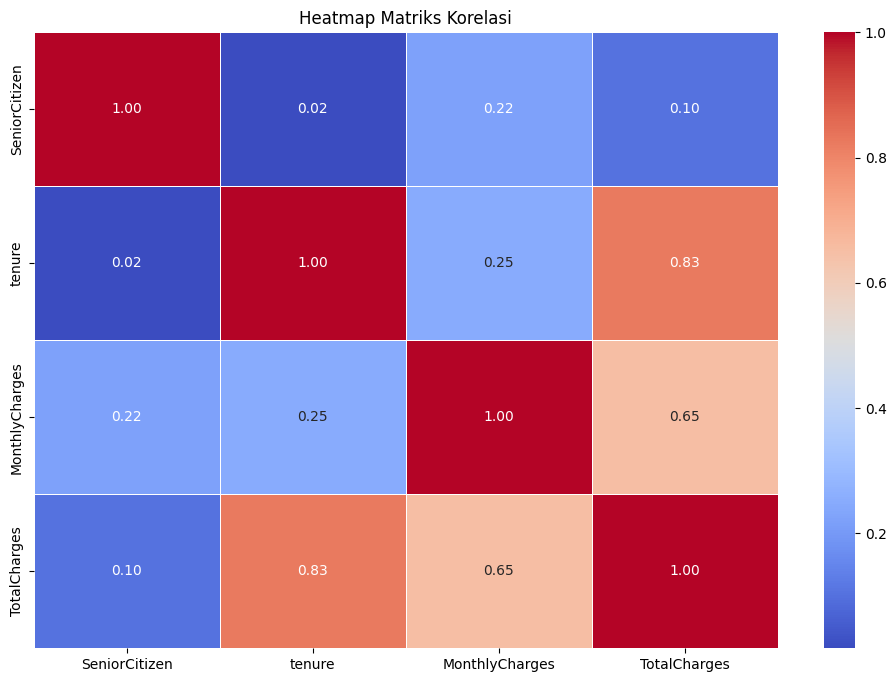

In [30]:
correlation_matrix = numeric_features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Heatmap Matriks Korelasi')
plt.show()

### 5. Missing Values

In [31]:
missing_values = data.isnull().sum()
print("Missing Values per Kolom:")
print(missing_values)

Missing Values per Kolom:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


### 6. Pengecekan Inkonsistensi

In [32]:
for column in categorical_features:
    print(f'{column}: {data[column].unique()}')

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


## Data Preprocessing

### 1. Penghapusan Fitur dengan Korelasi Tinggi dan Fitur Tidak Penting

Berdasarkan matriks korelasi, fitur TotalCharges memiliki korelasi yang tinggi dengan fitur tenure (0.83) dan MonthlyCharges (0.65). Oleh karena itu penghapusan dapat dikenakan terhadap fitur TotalCharges untuk mengurangi redundansi informasi, menyederhanakan dan mengurangi risiko overfitting.

Sementara itu, customerID yang nilainya unik untuk setiap baris adalah fitur yang tidak penting.

In [33]:
data = data.drop(columns=["TotalCharges", "customerID"])
data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,Yes


In [34]:
numeric_features = numeric_features.drop(columns="TotalCharges")
print(numeric_features)

      SeniorCitizen  tenure  MonthlyCharges
0                 0       1           29.85
1                 0      34           56.95
2                 0       2           53.85
3                 0      45           42.30
4                 0       2           70.70
...             ...     ...             ...
7038              0      24           84.80
7039              0      72          103.20
7040              0      11           29.60
7041              1       4           74.40
7042              0      66          105.65

[7043 rows x 3 columns]


### 2. Menghapus Baris Duplikat

Sebenarnya, kemungkinan adanya baris duplikat pada dataset ini cukup kecil. Akan tetapi, untuk berjaga-jaga, kode untuk menghapus baris duplikat tetap harus dijalankan. Baris duplikat dihapus dengan tujuan untuk mengurangi redundansi

In [35]:
data = data.drop_duplicates()

### 3. Memperbaiki Error dan Inkonsistensi

Berdasarkan hasil pemeriksaan inkonsistensi, dapat dilihat bahwa beberapa kolom memiliki kategori khusus seperti 'No phone service' atau 'No internet service'. Perbaikan perlu dilakukan untuk menjaga konsistensi dan memudahkan analisis lebih lanjut

In [36]:
data.loc[:, 'MultipleLines'] = data['MultipleLines'].replace({'No phone service': 'No'})
data.loc[:, 'OnlineSecurity'] = data['OnlineSecurity'].replace({'No internet service': 'No'})
data.loc[:, 'OnlineBackup'] = data['OnlineBackup'].replace({'No internet service': 'No'})
data.loc[:, 'DeviceProtection'] = data['DeviceProtection'].replace({'No internet service': 'No'})
data.loc[:, 'TechSupport'] = data['TechSupport'].replace({'No internet service': 'No'})
data.loc[:, 'StreamingTV'] = data['StreamingTV'].replace({'No internet service': 'No'})
data.loc[:, 'StreamingMovies'] = data['StreamingMovies'].replace({'No internet service': 'No'})

for column in categorical_features.columns:
    print(f'{column}: {data[column].unique()}')


gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


### 4. Normalisasi


Normalisasi dilakukan untuk memastikan bahwa semua feature berada pada skala yang sama, sehingga dapat membantu algoritma machine learning berfungsi lebih baik dan konvergen lebih cepat. Ini juga membantu dalam mengurangi bias dalam feature yang memiliki rentang nilai yang lebih besar.

In [37]:
scaler = StandardScaler()
data['MonthlyCharges'] = scaler.fit_transform(data[['MonthlyCharges']])
data['tenure'] = scaler.fit_transform(data[['tenure']])

C:\Users\WISMA\AppData\Local\Temp\ipykernel_14892\3676644215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MonthlyCharges'] = scaler.fit_transform(data[['MonthlyCharges']])
C:\Users\WISMA\AppData\Local\Temp\ipykernel_14892\3676644215.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tenure'] = scaler.fit_transform(data[['tenure']])


### 5. Encoding Feature Kategorikal

Model machine learning tidak bisa bekerja langsung dengan data kategori, sehingga fitur kategori perlu diubah menjadi format numerik. Label Encoding digunakan untuk fitur dengan dua kategori untuk menghindari urutan yang tidak semestinya, sedangkan One-Hot Encoding digunakan untuk fitur dengan lebih dari dua kategori untuk memastikan setiap kategori diwakili sebagai kolom biner yang terpisah, sehingga tidak ada urutan atau prioritas yang diberikan pada kategori-kategori tersebut.

In [38]:
categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
                        'PaperlessBilling', 'PaymentMethod', 'Churn']

label_enc = LabelEncoder()
for feature in categorical_features:
    if data[feature].nunique() == 2:
        data[feature] = label_enc.fit_transform(data[feature])

data = pd.get_dummies(data, columns=[feature for feature in categorical_features if data[feature].nunique() > 2])


C:\Users\WISMA\AppData\Local\Temp\ipykernel_14892\3371488037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature] = label_enc.fit_transform(data[feature])
C:\Users\WISMA\AppData\Local\Temp\ipykernel_14892\3371488037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[feature] = label_enc.fit_transform(data[feature])
C:\Users\WISMA\AppData\Local\Temp\ipykernel_14892\3371488037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

## Modeling dan Validasi

Sejujurnya, pemilihan metrik yang tepat sedikit membingungkan pada kasus ini. Precision penting untuk efisiensi sumber daya, sementara recall krusial untuk menangkap sebanyak mungkin pelanggan yang berisiko Churn. Setelah mempertimbangkan kompleksitas masalah churn, F-Score muncul sebagai pilihan terbaik. 
Sepertinya metrik ini menyeimbangkan precision dan recall dalam satu nilai, memungkinkan identifikasi akurat pelanggan berisiko churn sambil mengoptimalkan penggunaan sumber daya. 
F-Score juga efektif mengatasi ketidakseimbangan kelas pada data churn dan dapat disesuaikan dengan prioritas bisnis yang berubah. Dengan menggunakan F-Score, strategi retensi yang efektif dan efisien dapat dirancang, menangkap pelanggan berisiko tanpa memboroskan sumber daya pada yang tidak perlu.

### 1 Pemisahan Data

In [39]:
X = data.drop(columns="Churn").values
y = data['Churn'].values
X = X.astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [40]:
print(f"Tipe X: {type(X)}")

Tipe X: <class 'numpy.ndarray'>


Fungsi Bantuan

In [41]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    return accuracy, f1

In [43]:
def perform_kfold_cv(models, X, y, n_splits=5):

    print("K-Fold Cross-Validation\n")
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, model in models.items():
        accuracy_scores = []
        f1_scores = []

        for train_index, test_index in kf.split(X):
            X_train_kf, X_test_kf = X[train_index], X[test_index]
            y_train_kf, y_test_kf = y[train_index], y[test_index]

            model.fit(X_train_kf, y_train_kf)
            y_pred_kf = model.predict(X_test_kf)

            accuracy_scores.append(accuracy_score(y_test_kf, y_pred_kf))
            f1_scores.append(f1_score(y_test_kf, y_pred_kf))

        print(f"{name} (K-Fold Cross-Validation):")
        print(f"Cross-Validation Accuracy: {np.mean(accuracy_scores):.2f} ± {np.std(accuracy_scores):.2f}")
        print(f"Cross-Validation F1 Score: {np.mean(f1_scores):.2f} ± {np.std(f1_scores):.2f}\n")

### 2. Model

A. KNN (K-Nearest-Neighbors)

In [24]:
module_name = "knn"
module_path = os.path.join('supervised-learning', module_name + '.py')

spec = importlib.util.spec_from_file_location(module_name, module_path)
knn_module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = knn_module
spec.loader.exec_module(knn_module)

KNNScratch = knn_module.KNNScratch

In [154]:
models = {
    'KNNScratch': KNNScratch(k_neighbours=5),
    'KNN_Sklearn': KNeighborsClassifier(n_neighbors=5)
}


for name, model in models.items():
    accuracy, f1 = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"{name} on Test Set:")
    print(f"Test Accuracy: {accuracy:.2f}")
    print(f"Test F1 Score: {f1:.2f}\n")

KNNScratch on Test Set:
Test Accuracy: 0.77
Test F1 Score: 0.54

KNN_Sklearn on Test Set:
Test Accuracy: 0.77
Test F1 Score: 0.54



In [ ]:
perform_kfold_cv(models, X, y, n_splits=5)

K-Fold Cross-Validation

KNNScratch (K-Fold Cross-Validation):
Cross-Validation Accuracy: 0.77 ± 0.01
Cross-Validation F1 Score: 0.55 ± 0.01

KNN_Sklearn (K-Fold Cross-Validation):
Cross-Validation Accuracy: 0.77 ± 0.01
Cross-Validation F1 Score: 0.55 ± 0.01



B. Logistic Regression

In [44]:
module_name = "logistic-regression"
module_path = os.path.join('supervised-learning', module_name + '.py')

spec = importlib.util.spec_from_file_location(module_name, module_path)
logistic_module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = logistic_module
spec.loader.exec_module(logistic_module)

LogisticRegressionScratch = logistic_module.LogisticRegressionScratch

In [45]:
print(f"X_train type: {type(X_train)}, dtype: {X_train.dtype}")
print(f"y_train type: {type(y_train)}, dtype: {y_train.dtype}")


X_train type: <class 'numpy.ndarray'>, dtype: float64
y_train type: <class 'numpy.ndarray'>, dtype: int64


In [46]:
models = {
    'LogisticRegressionScratch': LogisticRegressionScratch(),
    'LogisticRegression_Sklearn': LogisticRegression()
}

for name, model in models.items():
    accuracy, f1 = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"{name} pada Set Test:")
    print(f"Akurasi Test: {accuracy:.2f}")
    print(f"F1 Score Test: {f1:.2f}\n")

Iteration 1/1000: Cost = 0.6931
Iteration 100/1000: Cost = 0.5524
Iteration 200/1000: Cost = 0.5094
Iteration 300/1000: Cost = 0.4858
Iteration 400/1000: Cost = 0.4704
Iteration 500/1000: Cost = 0.4597
Iteration 600/1000: Cost = 0.4521
Iteration 700/1000: Cost = 0.4464
Iteration 800/1000: Cost = 0.4420
Iteration 900/1000: Cost = 0.4387
Iteration 1000/1000: Cost = 0.4361
LogisticRegressionScratch pada Set Test:
Akurasi Test: 0.80
F1 Score Test: 0.54

LogisticRegression_Sklearn pada Set Test:
Akurasi Test: 0.81
F1 Score Test: 0.59



In [165]:
print(f"Checking X data: NaN values: {np.isnan(X).sum()}, inf values: {np.isinf(X).sum()}")
print(f"Checking y data: NaN values: {np.isnan(y).sum()}, inf values: {np.isinf(y).sum()}")

Checking X data: NaN values: 0, inf values: 0
Checking y data: NaN values: 0, inf values: 0


In [166]:
perform_kfold_cv(models, X, y, n_splits=5)

K-Fold Cross-Validation

Iteration 1/1000: Cost = 0.6931
Iteration 100/1000: Cost = 0.5560
Iteration 200/1000: Cost = 0.5135
Iteration 300/1000: Cost = 0.4901
Iteration 400/1000: Cost = 0.4748
Iteration 500/1000: Cost = 0.4642
Iteration 600/1000: Cost = 0.4566
Iteration 700/1000: Cost = 0.4509
Iteration 800/1000: Cost = 0.4467
Iteration 900/1000: Cost = 0.4434
Iteration 1000/1000: Cost = 0.4408
Iteration 1/1000: Cost = 0.6931
Iteration 100/1000: Cost = 0.5488
Iteration 200/1000: Cost = 0.5049
Iteration 300/1000: Cost = 0.4810
Iteration 400/1000: Cost = 0.4653
Iteration 500/1000: Cost = 0.4544
Iteration 600/1000: Cost = 0.4466
Iteration 700/1000: Cost = 0.4407
Iteration 800/1000: Cost = 0.4363
Iteration 900/1000: Cost = 0.4328
Iteration 1000/1000: Cost = 0.4301
Iteration 1/1000: Cost = 0.6931
Iteration 100/1000: Cost = 0.5478
Iteration 200/1000: Cost = 0.5041
Iteration 300/1000: Cost = 0.4803
Iteration 400/1000: Cost = 0.4649
Iteration 500/1000: Cost = 0.4541
Iteration 600/1000: Cost = 

C. Gaussian Naive Bayes

In [167]:
module_name = "gaussian-naive-bayes"
module_path = os.path.join('supervised-learning', module_name + '.py')

spec = importlib.util.spec_from_file_location(module_name, module_path)
gauss_naive_module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = gauss_naive_module
spec.loader.exec_module(gauss_naive_module)

GaussianNaiveBayesScratch = gauss_naive_module.GaussianNaiveBayes

In [168]:
models = {
    'GaussianNaiveBayesScratch': GaussianNaiveBayesScratch(),
    'GaussianNB_Sklearn': GaussianNB()
}

for name, model in models.items():
    accuracy, f1 = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"{name} pada Set Test:")
    print(f"Akurasi: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}\n")

Memulai proses fit...
Memproses kelas 0: mean=[ 0.50180006  0.13265024  0.52367765  0.34339518  0.21098125  0.8991969
  0.41512047  0.32816394  0.37441152  0.36388812  0.33674882  0.37385766
  0.36914982  0.53863196 -0.11196542  0.3777347   0.35170313  0.27056217
  0.42813625  0.25477707  0.31708668  0.24813071  0.25754639  0.24896151
  0.2453614 ], var=[0.24999676 0.11505415 0.24943937 0.22547493 0.964378   0.09064184
 0.24279546 0.22047237 0.23422753 0.23147356 0.22334905 0.23408811
 0.23287823 0.24850757 1.06507211 0.2350512  0.22800804 0.19735828
 0.2448356  0.18986571 0.21654272 0.18656186 0.19121625 0.18697967
 0.18515918]
Memproses kelas 1: mean=[ 0.50076923  0.25769231  0.36307692  0.17230769 -0.57005436  0.90615385
  0.46384615  0.16230769  0.29769231  0.30153846  0.16615385  0.45
  0.44461538  0.76153846  0.34099774  0.24692308  0.69923077  0.05384615
  0.88076923  0.09076923  0.02846154  0.13769231  0.13        0.57307692
  0.15923077], var=[0.24999941 0.19128698 0.23125207 

In [169]:
perform_kfold_cv(models, X, y, n_splits=5)

K-Fold Cross-Validation

Memulai proses fit...
Memproses kelas 0: mean=[ 0.50831296  0.13667482  0.53227384  0.34938875  0.20826129  0.9007335
  0.41589242  0.33691932  0.37359413  0.36821516  0.33398533  0.36381418
  0.37041565  0.53765281 -0.10720918  0.3794621   0.35354523  0.26699267
  0.42982885  0.25721271  0.31295844  0.24596577  0.25134474  0.25452323
  0.24816626], var=[0.24993089 0.11799481 0.2489584  0.22731625 0.96187256 0.08941266
 0.24292592 0.22340469 0.23402156 0.23263276 0.22243913 0.23145342
 0.2332079  0.24858227 1.06455096 0.23547062 0.228551   0.19570758
 0.24507601 0.19105433 0.21501545 0.18546661 0.18817056 0.18974115
 0.18657977]
Memproses kelas 1: mean=[ 0.49934297  0.25886991  0.36005256  0.16885677 -0.58398267  0.90341656
  0.45203679  0.1544021   0.27989488  0.29303548  0.16688568  0.44086728
  0.43561104  0.74704336  0.31236915  0.25164258  0.6892247   0.05913272
  0.88107753  0.0913272   0.02759527  0.14257556  0.12417871  0.56767411
  0.16557162], var=[0.

D. CART-classification

In [193]:
module_name = "cart-classification"
module_path = os.path.join('supervised-learning', module_name + '.py')

spec = importlib.util.spec_from_file_location(module_name, module_path)
cart_module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = cart_module
spec.loader.exec_module(cart_module)

CARTScratch = cart_module.CARTScratch

In [194]:
models = {
    'CARTScratch': CARTScratch(max_height=5),
    'DecisionTree_Sklearn': DecisionTreeClassifier(max_depth=5)
}

for name, model in models.items():
    accuracy, f1 = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"{name} pada Set Test:")
    print(f"Akurasi: {accuracy:.2f}")
    print(f"F1 Score: {f1:.2f}\n")

Memulai proses fitting data...
Menumbuhkan pohon pada depth 0 dengan 4911 sampel...
Pembagian terbaik ditemukan di fitur 18 dengan threshold 0.0.
Menumbuhkan pohon pada depth 1 dengan 2220 sampel...
Pembagian terbaik ditemukan di fitur 14 dengan threshold 0.9576285996343428.
Menumbuhkan pohon pada depth 2 dengan 1672 sampel...
Pembagian terbaik ditemukan di fitur 19 dengan threshold 0.0.
Menumbuhkan pohon pada depth 3 dengan 921 sampel...
Pembagian terbaik ditemukan di fitur 14 dengan threshold 0.9160361228721544.
Menumbuhkan pohon pada depth 4 dengan 913 sampel...
Pembagian terbaik ditemukan di fitur 4 dengan threshold 1.367502428850161.
Menumbuhkan pohon pada depth 5 dengan 570 sampel...
Leaf node terbentuk dengan nilai 0.
Menumbuhkan pohon pada depth 5 dengan 343 sampel...
Leaf node terbentuk dengan nilai 0.
Menumbuhkan pohon pada depth 4 dengan 8 sampel...
Pembagian terbaik ditemukan di fitur 14 dengan threshold 0.9176998219426419.
Menumbuhkan pohon pada depth 5 dengan 2 sampel...


In [195]:
perform_kfold_cv(models, X, y, n_splits=5)

K-Fold Cross-Validation

Memulai proses fitting data...
Menumbuhkan pohon pada depth 0 dengan 5612 sampel...
Pembagian terbaik ditemukan di fitur 18 dengan threshold 0.0.
Menumbuhkan pohon pada depth 1 dengan 2513 sampel...
Pembagian terbaik ditemukan di fitur 14 dengan threshold 0.9576285996343428.
Menumbuhkan pohon pada depth 2 dengan 1880 sampel...
Pembagian terbaik ditemukan di fitur 19 dengan threshold 0.0.
Menumbuhkan pohon pada depth 3 dengan 1022 sampel...
Pembagian terbaik ditemukan di fitur 1 dengan threshold 0.0.
Menumbuhkan pohon pada depth 4 dengan 950 sampel...
Pembagian terbaik ditemukan di fitur 23 dengan threshold 0.0.
Menumbuhkan pohon pada depth 5 dengan 893 sampel...
Leaf node terbentuk dengan nilai 0.
Menumbuhkan pohon pada depth 5 dengan 57 sampel...
Leaf node terbentuk dengan nilai 0.
Menumbuhkan pohon pada depth 4 dengan 72 sampel...
Pembagian terbaik ditemukan di fitur 14 dengan threshold 0.14075235602496347.
Menumbuhkan pohon pada depth 5 dengan 38 sampel...
L

E. SVM

In [50]:
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))

Unique values in y_train: [0 1]
Unique values in y_test: [0 1]


In [52]:
module_name = "svm-scratch"
module_path = os.path.join('supervised-learning', module_name + '.py')

spec = importlib.util.spec_from_file_location(module_name, module_path)
svm_module = importlib.util.module_from_spec(spec)
sys.modules[module_name] = svm_module
spec.loader.exec_module(svm_module)

SVM_Scratch = svm_module.SVM_Scratch

In [53]:
models = {
    'SVM_Scratch (Linear Kernel)': SVM_Scratch(kernel='linear'),
    'SVM_Scratch (Polynomial Kernel)': SVM_Scratch(kernel='polynomial', degree=3),
    'SVM_Sklearn (Linear Kernel)': SVC(kernel='linear'),
    'SVM_Sklearn (Polynomial Kernel)': SVC(kernel='poly', degree=3)
}


for name, model in models.items():
    accuracy, f1 = evaluate_model(model, X_train, y_train, X_test, y_test)
    print(f"{name} pada Set Test:")
    print(f"Akurasi Test: {accuracy:.2f}")
    print(f"F1 Score Test: {f1:.2f}\n")


SVM_Scratch (Linear Kernel) pada Set Test:
Akurasi Test: 0.81
F1 Score Test: 0.60

SVM_Scratch (Polynomial Kernel) pada Set Test:
Akurasi Test: 0.81
F1 Score Test: 0.60

SVM_Sklearn (Linear Kernel) pada Set Test:
Akurasi Test: 0.81
F1 Score Test: 0.61

SVM_Sklearn (Polynomial Kernel) pada Set Test:
Akurasi Test: 0.81
F1 Score Test: 0.57



In [54]:
perform_kfold_cv(models, X, y, n_splits=5)

K-Fold Cross-Validation

SVM_Scratch (Linear Kernel) (K-Fold Cross-Validation):
Cross-Validation Accuracy: 0.80 ± 0.01
Cross-Validation F1 Score: 0.59 ± 0.01

SVM_Scratch (Polynomial Kernel) (K-Fold Cross-Validation):
Cross-Validation Accuracy: 0.80 ± 0.01
Cross-Validation F1 Score: 0.59 ± 0.01

SVM_Sklearn (Linear Kernel) (K-Fold Cross-Validation):
Cross-Validation Accuracy: 0.80 ± 0.01
Cross-Validation F1 Score: 0.59 ± 0.02

SVM_Sklearn (Polynomial Kernel) (K-Fold Cross-Validation):
Cross-Validation Accuracy: 0.80 ± 0.01
Cross-Validation F1 Score: 0.56 ± 0.02

